In this notebook, we will demonstrate how to apply the GRBFNN model to a classification problem. We'll guide you through the correct usage and interpretation of the results.|

In [1]:
# Import necessary libraries
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader, TensorDataset
from gaussian_rbf_network_c import GaussianRBFNetworkC

We will utilize the digits dataset from scikit-learn, focusing on the data for the classes '3' and '8' to define a binary classification problem.

In [2]:
# Load and preprocess the dataset
digits = load_digits()
X, y = digits.data, digits.target

# Filter the dataset for classes '6' and '8'
mask = np.isin(y, [3, 8])
X, y = X[mask], y[mask]
y = (y == 8).astype(int)  # Binary classification (1 if '3', 0 if '8')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train)
X_test_st = scaler.transform(X_test)

# Convert data to torch tensors
X_train_st = torch.tensor(X_train_st, dtype=torch.float32)
X_test_st = torch.tensor(X_test_st, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

### Model Hyperparameters

The model assumes that RBF centers are provided as input. There are multiple ways to perform this step:

1. **Unsupervised Selection of Centers**: 
   - Centers can be selected using a clustering algorithm like k-means or as a random subset of the training data.
   - In this case, `learnable_centers` must be set to `False`.

2. **Supervised Selection of Centers**: 
   - Centers are treated as learnable parameters of the model.
   - Initial centers can be provided using one of the methods used in unsupervised selection.
   - In this case, `learnable_centers` must be set to `True`.

The model includes three regularizers that have to be fixed:

1. **Gaussian Regularizer**: 
   - Regularizes the entries of the precision matrix of the Gaussian kernel.
   - This is the most important regularizer.
   - Usual range from 1e-5 to 1e+3.

2. **Weights Regularizer**: 
   - Regularizes the weights that multiply the kernel.
   - Usual range from 1e-5 to 1e+3.

3. **Centers Regularizer**: 
   - This is used only if `learnable_centers` is set to `True`.
   - Regularizes the location of the centers.
   - It is generally not recommended to use high values for this hyperparameter. Setting it to less than `1e-4` should be sufficient.

The number of centers, the selection strategy used and the 3 regularizers are hyperparameters of the model and should be set through crossvalidation.

In [3]:
# Determine RBF centers using k-means clustering 
n_centers = 4  # Number of RBF centers
kmeans = KMeans(n_clusters=n_centers, random_state=0).fit(X_train_st)
centers = torch.tensor(kmeans.cluster_centers_, dtype=torch.float32)
learnable_centers=False
gaussian_reg, centers_reg, weights_reg= 1e-2, None, 1e-5

We train the model with a batch size of 256, using the Adam optimizer with a learning rate of 0.01 for up to 5000 epochs.


In [4]:
batch_size = 256
step_size = 0.01
model = GaussianRBFNetworkC(gaussian_regularizer=gaussian_reg, centers_regularizer=centers_reg, 
                            weights_regularizer=weights_reg, learnable_centers=learnable_centers, centers=centers, 
                            device='cpu')

# Create data loaders
train_dataset = TensorDataset(X_train_st, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Training settings
optimizer = optim.Adam(model.parameters(), lr=step_size)
n_epochs = 5000

# Training loop
for epoch in range(n_epochs):
    model.train()
    epoch_loss = 0.0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        y_hat = model(batch_X)
        loss = model.evaluate_loss(batch_y, y_hat)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    if epoch % 50 == 0:
        print(f'Epoch {epoch}, Loss: {epoch_loss / len(train_loader)}')

Epoch 0, Loss: 1.1477398872375488
Epoch 50, Loss: 0.989571213722229
Epoch 100, Loss: 0.869294285774231
Epoch 150, Loss: 0.7804337739944458
Epoch 200, Loss: 0.18231214582920074
Epoch 250, Loss: 0.048109445720911026
Epoch 300, Loss: 0.03019709326326847
Epoch 350, Loss: 0.02394718863070011
Epoch 400, Loss: 0.020444869995117188
Epoch 450, Loss: 0.018084626644849777
Epoch 500, Loss: 0.01637336239218712
Epoch 550, Loss: 0.015069462358951569
Epoch 600, Loss: 0.014039224945008755
Epoch 650, Loss: 0.013201845809817314
Epoch 700, Loss: 0.012506190687417984
Epoch 750, Loss: 0.011917702853679657
Epoch 800, Loss: 0.011412220075726509
Epoch 850, Loss: 0.01097257249057293
Epoch 900, Loss: 0.010586190968751907
Epoch 950, Loss: 0.010252498090267181
Epoch 1000, Loss: 0.009936417452991009
Epoch 1050, Loss: 0.009659717790782452
Epoch 1100, Loss: 0.009408959187567234
Epoch 1150, Loss: 0.00918031856417656
Epoch 1200, Loss: 0.008970741182565689
Epoch 1250, Loss: 0.008777663111686707
Epoch 1300, Loss: 0.00860

In [5]:
# Evaluate the model
model.eval()
with torch.no_grad():
    y_train_pred = model(X_train_st).numpy() > 0.5
    y_test_pred = model(X_test_st).numpy() > 0.5

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f'Train Accuracy: {train_accuracy}')
print(f'Test Accuracy: {test_accuracy}')

Train Accuracy: 1.0
Test Accuracy: 0.9907407407407407


We extract the learned precision matrix and compute the following:

1. **Eigenvectors**: These define the directions where the model exhibits the most variability, known as the active subspace.
2. **Eigenvalues**: These quantify the intensity of variation of the model in the directions defined by the corresponding eigenvectors.
3. **Feature Importance**: This assigns a coefficient to each input feature, describing its relevance in the model.


In [9]:
# Extract feature importance
precision_matrix = model.compute_precision(model.precision_elements)
feature_importance, eigenvalues, eigenvectors = model.feature_importance(precision_matrix)

Next, we will plot the feature importance for this application. Since our dataset consists of images, with each feature representing a pixel, we can easily visualize the feature importance vector.

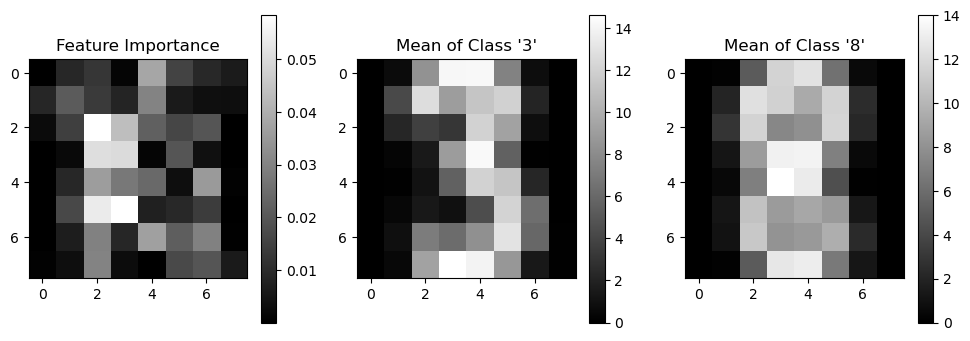

In [10]:
# Plot feature importance
feature_importance = feature_importance.detach().numpy().reshape(8, 8)
mean_3 = X[y == 0].mean(axis=0).reshape(8, 8)
mean_8 = X[y == 1].mean(axis=0).reshape(8, 8)

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title("Feature Importance")
plt.imshow(feature_importance, cmap='gray', interpolation='nearest')
plt.colorbar()

plt.subplot(1, 3, 2)
plt.title("Mean of Class '3'")
plt.imshow(mean_3, cmap='gray', interpolation='nearest')
plt.colorbar()

plt.subplot(1, 3, 3)
plt.title("Mean of Class '8'")
plt.imshow(mean_8, cmap='gray', interpolation='nearest')
plt.colorbar()
plt.show()

As we can see the feature importance vector highlights pixels where the classes '3' and '8' differ the most. 
Next we are going to plot the eigenvalues decay as: 
$ \frac{\gamma_k}{\sum_{k=1}^{K} \gamma_k}$
where $\gamma_k$ represents the $k$-th eigenvalue, and $K$is the total number of eigenvalues.

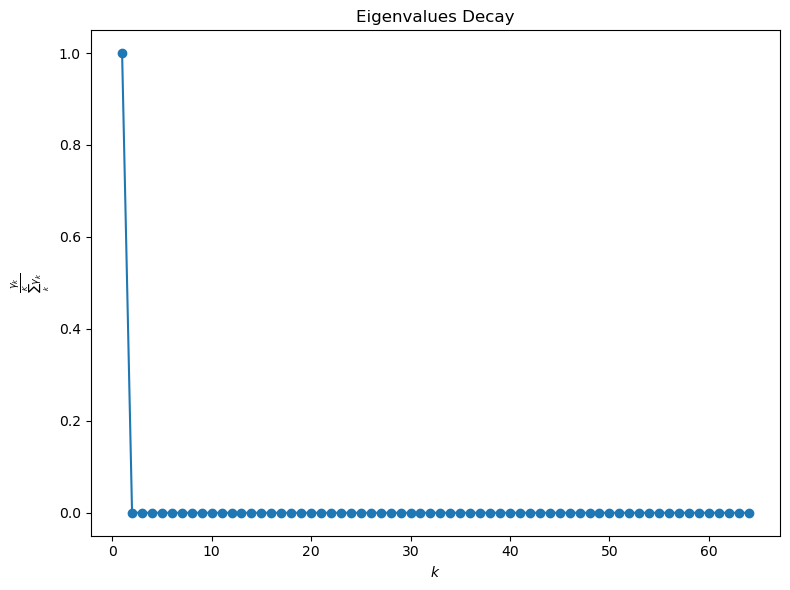

In [11]:
# Plot eigenvalues decay
gammas = eigenvalues.detach().numpy()[::-1] # sort eigenvalues
plt.figure(figsize=(8, 6))
plt.plot(np.arange(1, len(gammas) + 1), gammas / np.sum(gammas), marker='o', linestyle='-')
plt.xlabel('$k$')
plt.title("Eigenvalues Decay")
plt.ylabel(r'$\frac{\gamma_k}{\sum_k^K \gamma_k}$')
plt.tight_layout()
plt.show()

Only one eigenvalue is significantly different from zero, indicating that the model's variation occurs predominantly along a single direction defined by the corresponding eigenvector. This suggests that, despite the high dimensionality of some datasets, the actual variability captured by the model exists in a much lower-dimensional space.
Finally, we will visualize the active subspace in 2D.

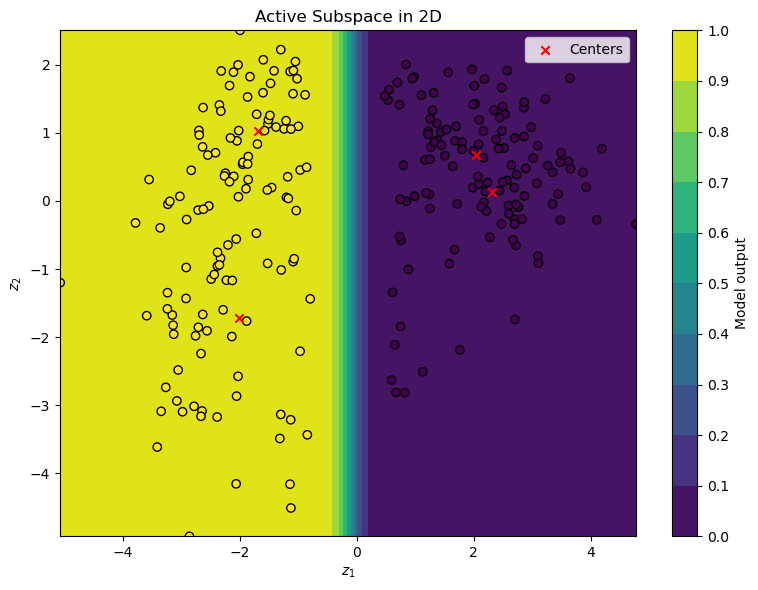

In [12]:
# Plot contours

V = eigenvectors.detach().numpy()[:, ::-1] # sort eigenvectors
Z = np.dot(X_train_st, V[:, :2]) # project data into the latent or active subspace defined by the top-2 eigenvectors

lb1, ub1 = min(Z[:, 0]), max(Z[:, 0])
lb2, ub2 = min(Z[:, 1]), max(Z[:, 1])
xx1 = np.linspace(lb1, ub1, 100)
xx2 = np.linspace(lb2, ub2, 100)

XX1, XX2 = np.meshgrid(xx1, xx2)
xx12 = np.vstack([XX1.ravel(), XX2.ravel()]).T
xx12_back = np.dot(xx12, V[:, :2].T) # reproject back data from the active subspace so that we can evaluate the model
xx12_back = torch.tensor(xx12_back, dtype=torch.float32)

XX3 = model(xx12_back).detach().numpy().reshape(XX1.shape) # obtan the model output


fig, ax = plt.subplots(figsize=(8, 6))
# Plot centers
centers_projected = np.dot(model.centers.detach().numpy(), V[:, :2])

contours = plt.contourf(XX1, XX2, XX3, cmap='viridis', levels=np.linspace(0, 1, 11))
cbar = plt.colorbar(contours)
cbar.set_label('Model output')
cbar.set_ticks(np.linspace(0, 1, 11))

plt.scatter(Z[:, 0], Z[:, 1], c=y_train, edgecolors='black')
plt.scatter(centers_projected[:, 0], centers_projected[:, 1], c='red', marker='x', label='Centers')

ax.set_xlabel('$z_1$')
ax.set_ylabel('$z_2$')
plt.title('Active Subspace in 2D')
plt.legend()
plt.tight_layout()
plt.show()

The key aspect to observe is the contour levels, which illustrate the shape of the learned model in 2D. Notably, the contour levels align predominantly with a single dimension, the latent variable $z_1$. This observation supports the finding that only one eigenvalue is significantly different from zero, indicating that the corresponding direction $v_1$ is sufficient to achieve high classification accuracy.
